# Imports

In [3]:
import custom_functions as fn
## Load the autoreload extension
%load_ext autoreload 
%autoreload 2

import tensorflow as tf
import numpy as np
# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

In [2]:
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers, optimizers, regularizers
from tensorflow.keras.models import Sequential
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 250)

In [1]:
from pprint import pprint
FPATHS = dict(
    data={
        "filtered":  "Data/reviews-filtered.csv",
        "processed": "Data/reviews_filtered.joblib",
        "ml": {
            "train": "Data/training-data.joblib",  
            "test": "Data/testing-data.joblib",
            
            "label_encoder":"Data/label-encoder.joblib",
            'target_lookup':"Data/target-lookup-dict.joblib",
            
        },
        "tf": {
            "train_tf": "Data/tf/training_tf",  
            "test_tf": "Data/tf/testing_tf", 
         },           
    },
    models={
        "rf": "models/random_forest/rf-pipe.joblib", 
        "nb": "models/nb/nb-pipe.joblib", 
        "gru": "models/tf/"
    },
    eda = {
        "scattertext": "eda/scattertext.html",
        "lemmas-high": "eda/high_cloud.png",
        'lemmas-low':"eda/low_cloud.png",
        'tokens-high':'eda/high_cloud_tokens.png',
        'tokens-low':'eda/low_cloud_tokens.png',
        'low-freq':'eda/low_freq_dist.png',
        'high-freq':'eda/high_freq_dist.png',
    }
)
pprint(FPATHS)

{'data': {'filtered': 'Data/reviews-filtered.csv',
          'ml': {'label_encoder': 'Data/label-encoder.joblib',
                 'target_lookup': 'Data/target-lookup-dict.joblib',
                 'test': 'Data/testing-data.joblib',
                 'train': 'Data/training-data.joblib'},
          'processed': 'Data/reviews_filtered.joblib',
          'tf': {'test_tf': 'Data/tf/testing_tf',
                 'train_tf': 'Data/tf/training_tf'}},
 'eda': {'high-freq': 'eda/high_freq_dist.png',
         'lemmas-high': 'eda/high_cloud.png',
         'lemmas-low': 'eda/low_cloud.png',
         'low-freq': 'eda/low_freq_dist.png',
         'scattertext': 'eda/scattertext.html',
         'tokens-high': 'eda/high_cloud_tokens.png',
         'tokens-low': 'eda/low_cloud_tokens.png'},
 'models': {'gru': 'models/tf/',
            'nb': 'models/nb/nb-pipe.joblib',
            'rf': 'models/random_forest/rf-pipe.joblib'}}


In [4]:
# Using function from Creating a File Structure Lesson
fn.create_directories_from_paths(FPATHS)

In [5]:
# Save the filepaths in a config folder
import os, json
os.makedirs('config/', exist_ok=True)
FPATHS_FILE = 'config/filepaths.json'
with open(FPATHS_FILE, 'w') as f:
    json.dump(FPATHS, f)

# Dataset

In [3]:
# Our dataset saved as a joblib has been previously processed with nulls and duplicates dropped
import joblib
fpath = "Data/NLP/reviews.joblib"
# Load the model
df = joblib.load(fpath)
df.head()

,original_title,review,rating,tokens,lemmas,tokens-joined,lemmas-joined
0,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife,...",7.0,"[fine, piece, cinema, wong, kar, wai, tells, story, people, circumstance, throws, way, expect, start, couples, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leaves, increasingly, loos...","[fine, piece, cinema, wong, kar, wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, e...",fine piece cinema wong kar wai tells story people circumstance throws way expect start couples new building newspaper man wife business executive wife businessman rarely home journalist wife leaves increasingly loose ends long friendship develops...,fine piece cinema wong kar wai tell story people circumstance throw way expect start couple new building newspaper man wife business executive wife businessman rarely home journalist wife leave increasingly loose end long friendship develop usual...
1,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",9.0,"[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation,guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation
2,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I l...",6.0,"[roommate, hates, stop, motion, animation, watched, 2018, good, time, maybe, great, remember, thinking, little, kid, holds, degree, final, rating, ★, ★, ★, liked, personally, recommend]","[roommate, hate, stop, motion, animation, watch, 2018, good, time, maybe, great, remember, think, little, kid, hold, degree, final, rating, ★, ★, ★, like, personally, recommend]",roommate hates stop motion animation watched 2018 good time maybe great remember thinking little kid holds degree final rating ★ ★ ★ liked personally recommend,roommate hate stop motion animation watch 2018 good time maybe great remember think little kid hold degree final rating ★ ★ ★ like personally recommend
3,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the fi...",8.0,"[good, stop, motion, animation, <, em>'chicken, run'</em, >, watched, crap, tonne, little, vast, number, years, impressive, production, given, came, 2000, despite, pretty, simple, feel, film, developed, concept, admittedly, short, run, time, trul...","[good, stop, motion, animation, <, em>'chicken, run'</em, >, watch, crap, tonne, little, vast, number, year, impressive, production, give, come, 2000, despite, pretty, simple, feel, film, develop, concept, admittedly, short, run, time, truly, fly...",good st

In [4]:
# We will split on each space, and then get the length
df['length'] =df['review'].map( lambda x: len(x.split(" ")))
df.head()

,original_title,review,rating,tokens,lemmas,tokens-joined,lemmas-joined,length
0,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife,...",7.0,"[fine, piece, cinema, wong, kar, wai, tells, story, people, circumstance, throws, way, expect, start, couples, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leaves, increasingly, loos...","[fine, piece, cinema, wong, kar, wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, e...",fine piece cinema wong kar wai tells story people circumstance throws way expect start couples new building newspaper man wife business executive wife businessman rarely home journalist wife leaves increasingly loose ends long friendship develops...,fine piece cinema wong kar wai tell story people circumstance throw way expect start couple new building newspaper man wife business executive wife businessman rarely home journalist wife leave increasingly loose end long friendship develop usual...,266
1,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",9.0,"[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation,guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation,41
2,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I l...",6.0,"[roommate, hates, stop, motion, animation, watched, 2018, good, time, maybe, great, remember, thinking, little, kid, holds, degree, final, rating, ★, ★, ★, liked, personally, recommend]","[roommate, hate, stop, motion, animation, watch, 2018, good, time, maybe, great, remember, think, little, kid, hold, degree, final, rating, ★, ★, ★, like, personally, recommend]",roommate hates stop motion animation watched 2018 good time maybe great remember thinking little kid holds degree final rating ★ ★ ★ liked personally recommend,roommate hate stop motion animation watch 2018 good time maybe great remember think little kid hold degree final rating ★ ★ ★ like personally recommend,56
3,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the fi...",8.0,"[good, stop, motion, animation, <, em>'chicken, run'</em, >, watched, crap, tonne, little, vast, number, years, impressive, production, given, came, 2000, despite, pretty, simple, feel, film, developed, concept, admittedly, short, run, time, trul...","[good, stop, motion, animation, <, em>'chicken, run'</em, >, watch, crap, tonne, little, vast, number, year, impressive, production, give, come, 2000, despite, pretty, simple, feel, film, develop, concept, admittedly, short, run, time, truly

In [5]:
# Retreiving the average review length for later
np.mean(df['length']).round(0)

238.0

### All reviews with null ratings were previously dropped in the NLP Analysis notebook

### Only high (9+) and low (4-) reviews are the focus of our Language Modeling. 

# Preprocessing

In [6]:
# Filtering high and low reviews
filter_h = df['rating'] >= 9.0
filter_l = df['rating'] <= 4.0
# Applying
filtered_df = df.loc[filter_h | filter_l].copy()
filtered_df.head(3)

,original_title,review,rating,tokens,lemmas,tokens-joined,lemmas-joined,length
1,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",9.0,"[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation,guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation,41
6,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully...",3.0,"[underwhelmed, straight, bored, course, seeing, hunt, climb, mountain, harness, impressive, sure, liked, idea, villain, piece, angle, woefully, underdeveloped, setting, predominantly, australia, grab, attention, saying, cause, pretty, biased, com...","[underwhelme, straight, bore, course, see, hunt, climb, mountain, harness, impressive, sure, like, idea, villain, piece, angle, woefully, underdeveloped, set, predominantly, australia, grab, attention, say, cause, pretty, biased, come, hear, tell...",underwhelmed straight bored course seeing hunt climb mountain harness impressive sure liked idea villain piece angle woefully underdeveloped setting predominantly australia grab attention saying cause pretty biased comes hear tell mission impossi...,underwhelme straight bore course see hunt climb mountain harness impressive sure like idea villain piece angle woefully underdeveloped set predominantly australia grab attention say cause pretty biased come hear tell mission impossible ii low poi...,118
7,Mission: Impossible II,After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf...,2.0,"[entertainign, mission, impossible, second, installment, turned, terrible, screenwriters, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scenes, horrible, need, barf, bag, stand, slo, mo, seconds, 15, seconds, amazed, decide, push, m,...","[entertainign, mission, impossible, second, installment, turn, terrible, screenwriter, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scene, horrible, need, barf, bag, stand, slo, mo, second, 15, second, amazed, decide, push, m, movie...",entertainign mission impossible second installment turned terrible screenwriters know fill 2 hrs action overuse heroic slow motion scenes horrible need barf bag stand slo mo seconds 15 seconds amazed decide push m movies turned better hard beat l...,entertainign mission impossible second installment turn terrible screenwriter know fill 2 hrs action overuse heroic slow motion scene horrible need barf bag stand slo mo second 15 second amazed decide push m movie turn well hard beat lousy piece ...,94


In [7]:
# Double checking values were filtered properly
filtered_df['rating'].value_counts()

9.0     616
10.0    564
4.0     514
1.0     284
3.0     254
2.0     153
9.5      15
0.5      10
3.5       4
1.5       3
2.5       2
Name: rating, dtype: int64

In [8]:
# With all the ratings in both categories we want, let's create a map for targets, lows as 0 and highs as 1.
target_map = {0.5:0, 1.0:0, 1.5:0, 2.0:0, 2.5:0, 3.0:0, 3.5:0, 4.0:0,
              9.0:1, 9.5:1, 10.0:1}
# Define y and apply the target_map
y = filtered_df['rating'].map(target_map)
X = filtered_df['review']

In [9]:
# Checking class balance
y.value_counts(normalize=True)

0    0.505994
1    0.494006
Name: rating, dtype: float64

In [10]:
# Target well balanced
# Defining classes as variable
classes = y.unique()
classes

array([1, 0], dtype=int64)

In [11]:
reviews_filtered = pd.concat([X,y], axis=1)

In [12]:
reviews_filtered.head(3)

,review,rating
1,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",1
6,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully...",0
7,After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf...,0


In [13]:
import joblib
joblib.dump(reviews_filtered, 'Data/reviews_filtered.joblib')

['Data/reviews_filtered.joblib']

In [14]:
reviews_filtered.to_csv('Data/reviews_filtered.csv')

# Machine Learning

In [15]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Vectorizor & Random Forest Model

In [16]:
# We'll try a tfidf vectorizer, more sophisticated than count and weighs words on frequency basis
tfidf_vectorizer = TfidfVectorizer()
# instantiate a vectorizer
tfidf_vectorizer.fit(X_train)

TfidfVectorizer()

In [17]:
# How many words in vocabulary
len(tfidf_vectorizer.vocabulary_)

23156

In [18]:
# Instantiating random forest
clf = RandomForestClassifier(random_state=42)

In [19]:
# Create a pipeline with a vectorizer and classification model.
clf_pipe = Pipeline([('vectorizer', TfidfVectorizer(stop_words='english')),
                     ('clf', RandomForestClassifier(random_state=42))])
clf_pipe

Pipeline(steps=[('vectorizer', TfidfVectorizer(stop_words='english')),
                ('clf', RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       926
           1       1.00      1.00      1.00       888

    accuracy                           1.00      1814
   macro avg       1.00      1.00      1.00      1814
weighted avg       1.00      1.00      1.00      1814



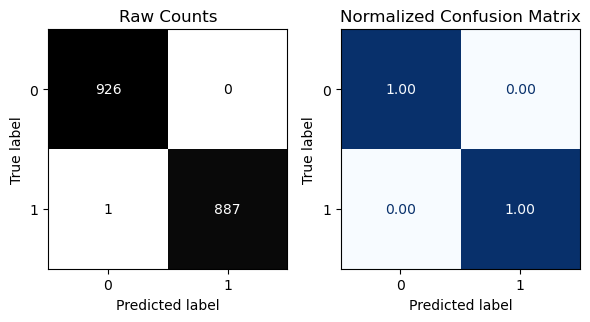


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       298
           1       0.85      0.84      0.84       307

    accuracy                           0.84       605
   macro avg       0.84      0.84      0.84       605
weighted avg       0.84      0.84      0.84       605



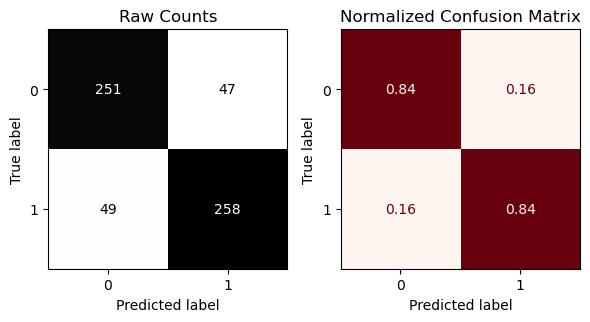

In [20]:
# Fit the model pipeline
clf_pipe.fit(X_train, y_train)
# Evaluate
fn.evaluate_classification(clf_pipe, X_train, y_train, X_test, y_test)

In [24]:
fpath_rf_pipe = FPATHS['models']['rf']
joblib.dump(clf_pipe, fpath_rf_pipe)

['models/random_forest/rf-pipe.joblib']

## GridSearch Text Vectorizer

In [26]:
# Retreiving parameters to tune
clf_pipe.get_params()

{'memory': None,
 'steps': [('vectorizer', TfidfVectorizer(stop_words='english')),
  ('clf', RandomForestClassifier(random_state=42))],
 'verbose': False,
 'vectorizer': TfidfVectorizer(stop_words='english'),
 'clf': RandomForestClassifier(random_state=42),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.float64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__norm': 'l2',
 'vectorizer__preprocessor': None,
 'vectorizer__smooth_idf': True,
 'vectorizer__stop_words': 'english',
 'vectorizer__strip_accents': None,
 'vectorizer__sublinear_tf': False,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__use_idf': True,
 'vectorizer__vocabulary': None,
 'clf__bootstrap': True,
 'c

In [29]:
param_grid = {
    "vectorizer__max_df": [1, 1.5, 2],
    'vectorizer__min_df': [0.6, 0.8, 1.0], 
    "vectorizer__max_features": [None, 500, 1000, 2000],
    "vectorizer__ngram_range": [(1, 1), (1, 2),(2,2)],
    "vectorizer__stop_words": [None,'english'],
    "clf__ccp_alpha": [0.0, .5, 1]
}

In [30]:
%%time
# Create grid search
grid_search = GridSearchCV(clf_pipe, param_grid, cv=3,verbose=2, n_jobs=-1)
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
432 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
432 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\sklearn\pipeline.py", line 359, in _fit
    X, f

CPU times: total: 21.4 s
Wall time: 27min 28s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__ccp_alpha': [0.0, 0.5, 1],
                         'vectorizer__max_df': [0.6, 0.8, 1],
                         'vectorizer__max_features': [None, 500, 1000, 2000],
                         'vectorizer__min_df': [1, 2, 3],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'vectorizer__stop_words': [None, 'english']},
             verbose=2)

In [31]:
grid_search.best_params_

{'clf__ccp_alpha': 0.0,
 'vectorizer__max_df': 0.6,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 2,
 'vectorizer__ngram_range': (1, 2),
 'vectorizer__stop_words': 'english'}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       926
           1       1.00      1.00      1.00       888

    accuracy                           1.00      1814
   macro avg       1.00      1.00      1.00      1814
weighted avg       1.00      1.00      1.00      1814



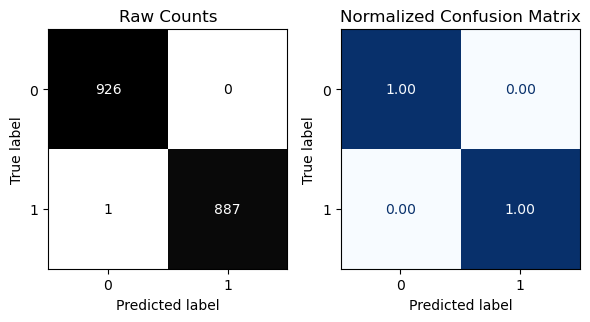


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       298
           1       0.82      0.86      0.84       307

    accuracy                           0.83       605
   macro avg       0.83      0.83      0.83       605
weighted avg       0.83      0.83      0.83       605



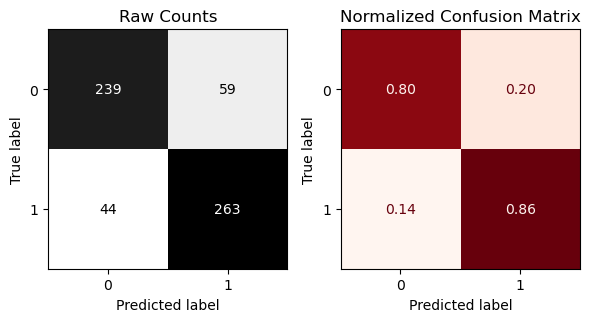

In [33]:
# Now define the best version of the model
best_model = grid_search.best_estimator_

# Predict and Evaluate with the custom function
fn.evaluate_classification(best_model, X_train, y_train, X_test, y_test)

### With tuned parameters we could spot more positive reviews, however overall accuracy dipped by a percent. We will test an RNN model next

# RNN Models

## Splitting and Validation

In [14]:
# Convert to Dataset Object
ds = tf.data.Dataset.from_tensor_slices((X, y))
# Shuffle dataset
ds = ds.shuffle(buffer_size=len(ds),reshuffle_each_iteration=False)

In [15]:
import math
BATCH_SIZE = 50
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )
# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)
# How many batches? 
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)
print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")

    - train:	1693 samples 	(34 batches)
    - val:  	483 samples 	(10 batches)
    - test: 	243 samples 	(5 batches)


In [17]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)
## Shuffling just the training data  
train_ds  = train_ds.shuffle(buffer_size = len(train_ds))
# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)
# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)
# Confirm len of train_ds
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 34 training batches.
 There are 10 validation batches.
 There are 5 testing batches.


In [18]:
# taking a sample 
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X)
print(example_y)

tf.Tensor(
[b'Writer-director Wes Anderson has lost his way, and this film proves it. I realize that the auteur\xe2\x80\x99s signature style of filmmaking is an acquired taste, and, to his credit, he\xe2\x80\x99s made some fine pictures over the years. But this one is not among them. In fact, contrary to many of the inexplicable claims that this is his finest release, I\xe2\x80\x99d contend just the opposite. It\xe2\x80\x99s arguably his worst, a meandering, cryptic, unfocused piece that\xe2\x80\x99s so muddled you\xe2\x80\x99ll need the assistance of a search party to find your way out of it (that is, if you even care by the time the end of this overlong mess rolls around). The director appears to have become so enamored with his own eccentricity that it doesn\xe2\x80\x99t even seem to matter to him whether or not viewers are on the same page as he is. Admittedly, this offering once again captures Anderson\xe2\x80\x99s singularly stylish look with a stunning production design and gorg

In [19]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)
# Preview the text
ds_texts.take(1).get_single_element()

<tf.Tensor: shape=(50,), dtype=string, numpy=
array([b'There have been plenty of movies based on classical cartoon superheroes that have been poorly implemented and with a lousy story. Luckily this one is not one of those. This was really a very enjoyable movie and I liked this movie a lot better than the first Thor movie which I felt was mostly silly.\r\n\r\nThis one has a story which was rather okay and held somewhat together. You have to remember that this is a comic book hero and the story is on that level of course. The special effects and the scenery is really nice as well. The views of Asgard is cool, almost breathtaking.\r\n\r\nAnthony Hopkins was excellent as Odin or Oden has he is called in Sweden, my country of birth. Tom Hiddleston is also very good in his role although I have to say that I really do not like his role but then he is supposed to be one of the bad guys so\xe2\x80\xa6 Chris Hemsworth is good enough in his role but I would say that he is really the weakest ones

## Text Vectorizer

In [40]:
# To place sequence length, we should review stats
df['length'].describe()

count    7454.000000
mean      238.282801
std       302.562629
min         1.000000
25%        71.000000
50%       167.000000
75%       293.000000
max      4246.000000
Name: length, dtype: float64

In [20]:
# Define sequence length as a variable for future use
SEQUENCE_LENGTH = 300
# Define vectorizer layer. Use the custom function to build and fit the vectorizer before using it in model
vectorizer, lookup = fn.make_text_vectorization_layer(train_ds, output_mode='int',output_sequence_length=SEQUENCE_LENGTH, verbose=True)
# Check the size of the vocabulary
VOCAB_SIZE = len(vectorizer.get_vocabulary())


tf.keras.layers.TextVectorization(
{   'batch_input_shape': (None,),
    'dtype': 'string',
    'encoding': 'utf-8',
    'idf_weights': None,
    'max_tokens': None,
    'name': 'text_vectorization',
    'ngrams': None,
    'output_mode': 'int',
    'output_sequence_length': 300,
    'pad_to_max_tokens': False,
    'ragged': False,
    'sparse': False,
    'split': 'whitespace',
    'standardize': 'lower_and_strip_punctuation',
    'trainable': True,
    'vocabulary': None,
    'vocabulary_size': 24923}
)


In [21]:
vectorizer.adapt(ds_texts)
vectorizer.vocabulary_size()

24923

In [22]:
# Define output dimension
EMBED_DIM = 100

## Simple GRU

In [52]:
def build_gru_model(text_vectorization_layer):
                
    gru_model = Sequential([
        text_vectorization_layer,
        tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)])
    # Add GRU layer *new*
    gru_model.add(layers.GRU(128, return_sequences = True))   
    gru_model.add(layers.GlobalMaxPooling1D())
    # Output layer
    gru_model.add(layers.Dense(len(classes), 
                              activation='softmax'))
        
    optimizer = optimizers.legacy.Adam()
    gru_model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model.summary()
    return gru_model

In [23]:
# Include callbacks
def get_callbacks(patience=5, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 300)              0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 300, 100)          2507200   
                                                                 
 gru (GRU)                   (None, 300, 128)          88320     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 2,595,778
Trainable params: 2,595,778
Non-

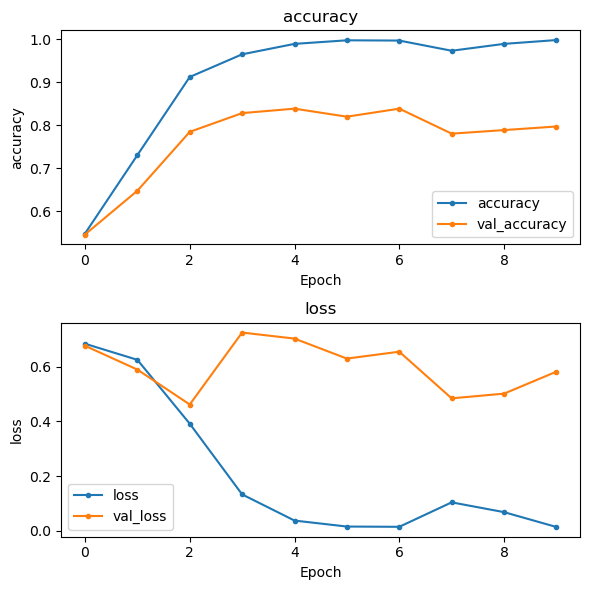


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       853
           1       1.00      1.00      1.00       840

    accuracy                           1.00      1693
   macro avg       1.00      1.00      1.00      1693
weighted avg       1.00      1.00      1.00      1693



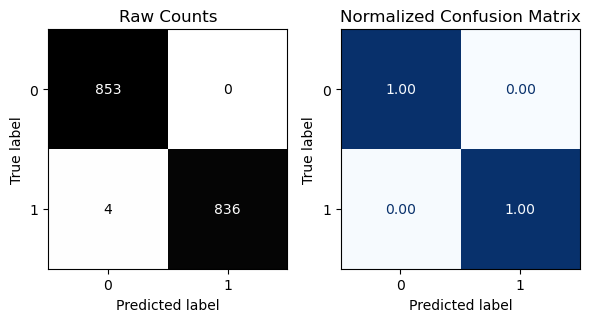


- Evaluating Training Data:
34/34 [==============================] - 2s 64ms/step - loss: 0.0090 - accuracy: 0.9976
{'loss': 0.009002501145005226, 'accuracy': 0.9976373314857483}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.90      0.80       110
           1       0.90      0.71      0.79       133

    accuracy                           0.79       243
   macro avg       0.81      0.80      0.79       243
weighted avg       0.81      0.79      0.79       243



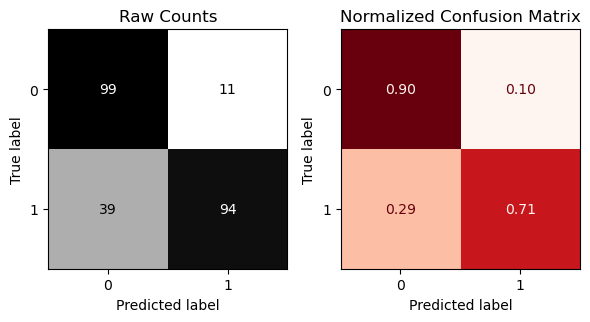


- Evaluating Test Data:
5/5 [==============================] - 0s 70ms/step - loss: 0.4769 - accuracy: 0.7942
{'loss': 0.476918488740921, 'accuracy': 0.7942386865615845}


In [56]:
# Build the model
model = build_gru_model(vectorizer)
# Fit the model
EPOCHS = 30
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    validation_data = val_ds,
    callbacks = get_callbacks(),
)
# Evaluate the model
results = fn.evaluate_classification_network(
    model, X_train=train_ds, 
    X_test = test_ds, history = history);

### Performance was fair for a simple model reaching 79%. This doesn't quite match the original rf pipe model.

## Stacked GRU

In [26]:
def build_gru_model_stack_deep_pool(text_vectorization_layer):
    
    
    MAX_TOKENS = text_vectorization_layer.vocabulary_size()
        
    model = tf.keras.Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)])

    # Stack three GrU layers    
    model.add(layers.GRU(128, return_sequences=True))
    model.add(layers.Dropout(.5))
    model.add(layers.GRU(128, return_sequences=True))
    model.add(layers.Dropout(.5))         
    # For the final GRU layer, use return_sequences = True for pooling layer
    model.add(layers.GRU(128, return_sequences = True)) 
    model.add(layers.GlobalMaxPooling1D())
    # Output layer
    model.add(layers.Dense(len(y.unique()), 
                              activation='softmax'))

              
    # Define optimizer
    optimizer = optimizers.legacy.Adam()

    # Compile
    model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 300)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 300, 100)          2492300   
                                                                 
 gru_3 (GRU)                 (None, 300, 128)          88320     
                                                                 
 dropout_2 (Dropout)         (None, 300, 128)          0         
                                                                 
 gru_4 (GRU)                 (None, 300, 128)          99072     
                                                                 
 dropout_3 (Dropout)         (None, 300, 128)          0         
                                                      

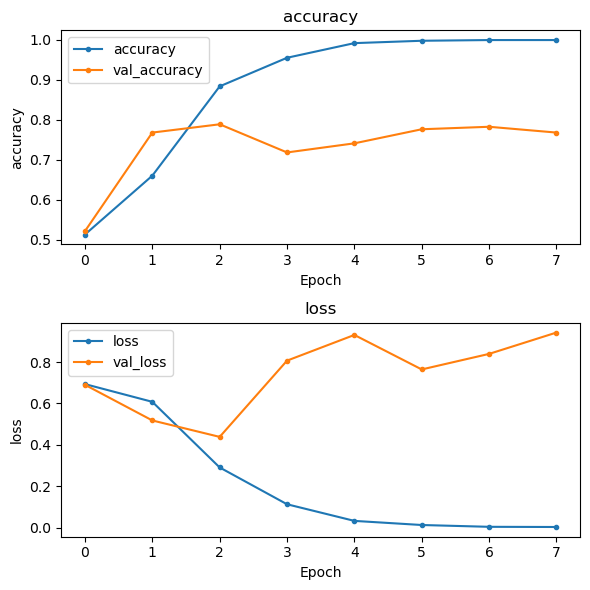


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.66      0.75       130
           1       0.69      0.88      0.78       113

    accuracy                           0.77       243
   macro avg       0.78      0.77      0.76       243
weighted avg       0.79      0.77      0.76       243



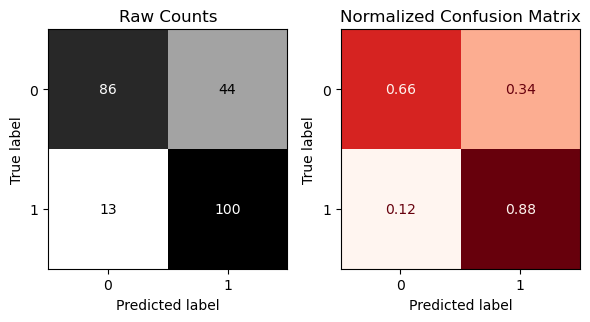


- Evaluating Test Data:
5/5 [==============================] - 4s 888ms/step - loss: 0.9890 - accuracy: 0.7654
{'loss': 0.9890040159225464, 'accuracy': 0.7654321193695068}


In [27]:
# Build model
model = build_gru_model_stack_deep_pool(vectorizer)

EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
results = fn.evaluate_classification_network(
    model,
    X_test=test_ds, history=history
);

## Bi-Directional GRU

In [59]:
def build_gru_model_bi_pool(text_vectorization_layer):
    
    gru_model_bi_pool = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                      output_dim=EMBED_DIM,
                      input_length=SEQUENCE_LENGTH)])
        
    # Add bidirectional component to GRU layer 
    gru_model_bi_pool.add(layers.Bidirectional(layers.GRU(128, return_sequences = True)))
    
    # Add a pooling layer *new
    gru_model_bi_pool.add(layers.GlobalMaxPooling1D())
    
    # Output layer
    gru_model_bi_pool.add(layers.Dense(len(classes), activation='softmax'))
                     
    optimizer = optimizers.legacy.Adam()
    gru_model_bi_pool.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model_bi_pool.summary()
    return gru_model_bi_pool

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 300)              0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 300, 100)          2507200   
                                                                 
 bidirectional (Bidirectiona  (None, 300, 256)         176640    
 l)                                                              
                                                                 
 global_max_pooling1d_2 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                      

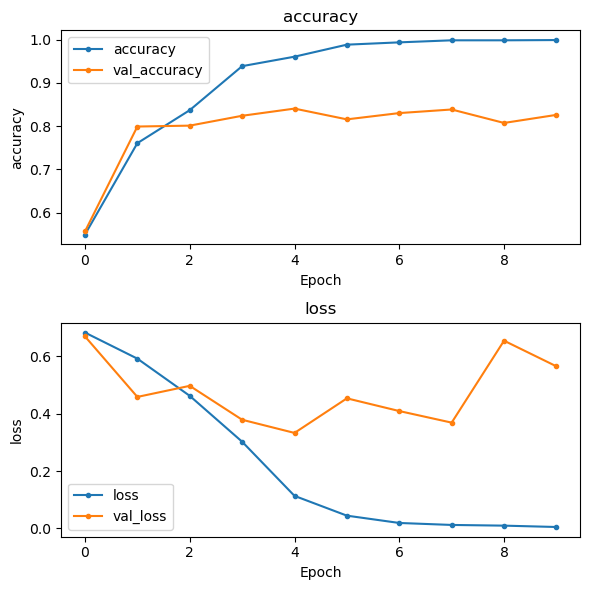


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       853
           1       1.00      1.00      1.00       840

    accuracy                           1.00      1693
   macro avg       1.00      1.00      1.00      1693
weighted avg       1.00      1.00      1.00      1693



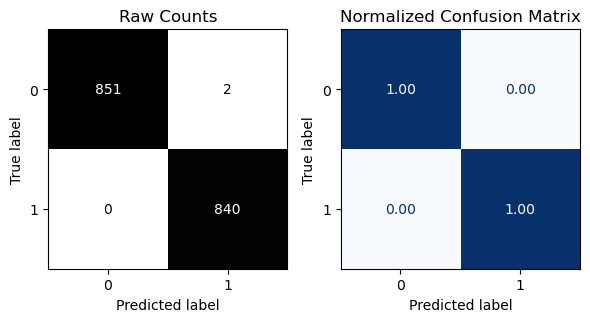


- Evaluating Training Data:
34/34 [==============================] - 4s 114ms/step - loss: 0.0044 - accuracy: 0.9988
{'loss': 0.004421901423484087, 'accuracy': 0.9988186359405518}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.87      0.78       110
           1       0.87      0.69      0.77       133

    accuracy                           0.77       243
   macro avg       0.78      0.78      0.77       243
weighted avg       0.79      0.77      0.77       243



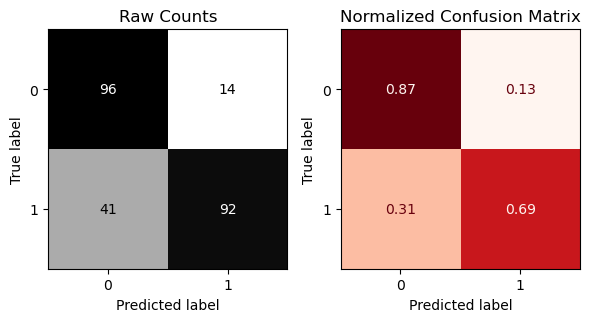


- Evaluating Test Data:
5/5 [==============================] - 1s 109ms/step - loss: 0.6930 - accuracy: 0.7737
{'loss': 0.6929893493652344, 'accuracy': 0.7736625671386719}


In [61]:
# Build the model
model = build_gru_model_bi_pool(vectorizer)

# Fit the model
EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

# Evaluate the model
results = fn.evaluate_classification_network(
    model, X_train=train_ds, 
    X_test=test_ds, history=history);

### For ease of computing mixed with decent accuracy(79%), the Bi-Directional GRU has the best record of the RNNs used. Still, it doesn't match the original Random Forest Classifier with Tfidf vectorizer reaching ~84% accuracy.